# Проект: Определение возраста клиентов по фотографии

**Оглавление**<a id='toc0_'></a>    
- 1. [Исследовательский анализ данных](#toc1_)    
  - 1.1. [Вывод по результатам раздела](#toc1_1_)    
- 2. [Обучение модели](#toc2_)    
- 3. [Анализ обученной модели. Выводы](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Задание:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, для выполнения следующих задач:
- анализ покупок и предложение товаров, которые могут заинтересовать покупателей этой возрастной группы;
- контроль добросовестности кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

Для построение и обучения модели предоставлен набор фотографий людей с указанием возраста.

Метрика качества модели - средняя абсолютная ошибка (MAE), её значение на тестовой выборке должно быть не больше 8.

План работы:
1. Исследовательский анализ данных.
2. Обучение модели.
3. Анализ обученной модели.

## 1. <a id='toc1_'></a>[Исследовательский анализ данных](#toc0_)

Выполним подключение необходимых библиотек, загрузим и проанализируем имеющиеся данные.

In [1]:
# подключение библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# определение констант
RST = 12345
PATH = '/datasets/faces/'
PATH_IMG = '/datasets/faces/final_files/'

In [2]:
# загрузка списка с фотографиями и возрастом в датасет
data = pd.read_csv(PATH + 'labels.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
7281,007301.jpg,1
7218,007236.jpg,5
5427,005427.jpg,20
5407,005407.jpg,25
1419,001419.jpg,20



Количество полных дубликатов: 0


Статистическая информация:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


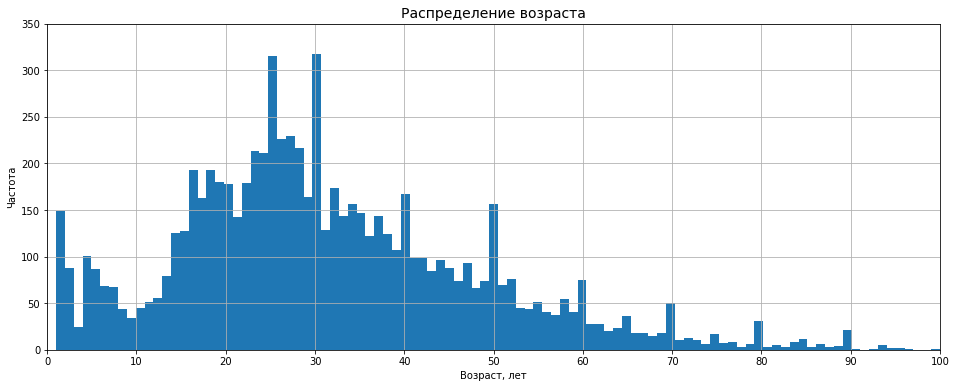

In [3]:
# обзор данных в датасете
data.info()
display(pd.concat([data.head(5), data.sample(5), data.tail(5)]))

# проверка на наличие дубликатов
print('\nКоличество полных дубликатов:', data.duplicated().sum(), end='\n\n')

# отображение статистической информации
print('\nСтатистическая информация:')
display(data.describe())

# постоение гистограммы распределения возрастов
data.real_age.hist(bins=100, figsize=(16,6))
plt.title('Распределение возраста', fontsize=14)
plt.ylabel('Частота')
plt.xlabel('Возраст, лет')
plt.xticks(range(0, 101, 10))
plt.xlim(0, 100)
plt.ylim(0, 350)
plt.show()

Рассмотрев данные в файле с названиями фотографий и соответствующим им возрастом можно заметить следующее:
- В базе более 7,5 тыс. фотографий с указанием возраста изображенных на них людей.
- Пропусков в данных нет, дубликатов нет, типы данных столбцов соответствуют их содержанию.
- Файлы фотографий хранятся в формате со сжатием `.jpg`. Названия файлов в основном соответствуют их порядковому номеру. В конце списка есть несоответствие, возможно, часть фотографий была удалена или заменена. Для исследования это не критично.
- Информация по статистичесим данным и гистограмме распределения возрастов:
    - Распределение возрастов имеет форму, схожую с распределением Пуассона, с положительной асимметрией и выбросами.
    - Диапазон возрастов содержит реальные значения от 1 до 100 лет.
    - Среднее и медиана имеют близкие значения - 31,2 года и 29 лет, соответственно.
    - В диапазоне возрастов от 1 до 7 лет наблюдается повышенная частота этих значений в выборке, за исключением возраста 3 лет. Предположительно в выборку была целенаправленно добавлена группа фотографий детей дошкольного возраста для более четкой их идентификации. Всплеск количества значений для возраста 1 год, возможно, вызван затруднением в точном определении возраста очень маленьких детей. Значение провала количества значений для возраста 3 года сложно идентифицировать, возможно, потеря части данных.
    - По всему диапазону наблюдаются вспрески количества значений на "круглых" датах возрастов, кратных 10, а также для возраста 25 лет. Скорее всего, это связано с подсознательным огруглением возраста человека до десятков лет при определении возраста по фотографии со стороны разметчиков данных.

Рассмотрим исходные размеры имеющихся фотографий, чтобы определиться со степенью сжатия для целевого формата фотографий.

In [4]:
%%time

# определение ширины и высоты исходных фото в пикселях и добавление их в датасет
for i in range(data.shape[0] - 1):
    img = Image.open(PATH_IMG + data['file_name'][i])
    data.loc[i, 'width'], data.loc[i, 'height'] = img.size

# отображение результата
data.info()
display(pd.concat([data.head(5), data.sample(5), data.tail(5)]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  7591 non-null   object 
 1   real_age   7591 non-null   int64  
 2   width      7590 non-null   float64
 3   height     7590 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 237.3+ KB


,file_name,real_age,width,height
0,000000.jpg,4,114.0,114.0
1,000001.jpg,18,784.0,784.0
2,000002.jpg,80,133.0,133.0
3,000003.jpg,50,370.0,370.0
4,000004.jpg,17,212.0,212.0
6056,006059.jpg,39,174.0,174.0
4724,004724.jpg,28,587.0,586.0
6500,006504.jpg,42,304.0,303.0
5734,005734.jpg,41,319.0,319.0
5935,005936.jpg,4,173.0,173.0


CPU times: user 8.26 s, sys: 1.25 s, total: 9.51 s
Wall time: 1min 52s


,width,height
count,7590.000000,7590.000000
mean,464.750725,464.110804
std,330.853289,331.308445
min,47.000000,47.000000
25%,220.000000,220.000000
50%,385.000000,384.000000
75%,632.000000,632.000000
max,4466.000000,4466.000000


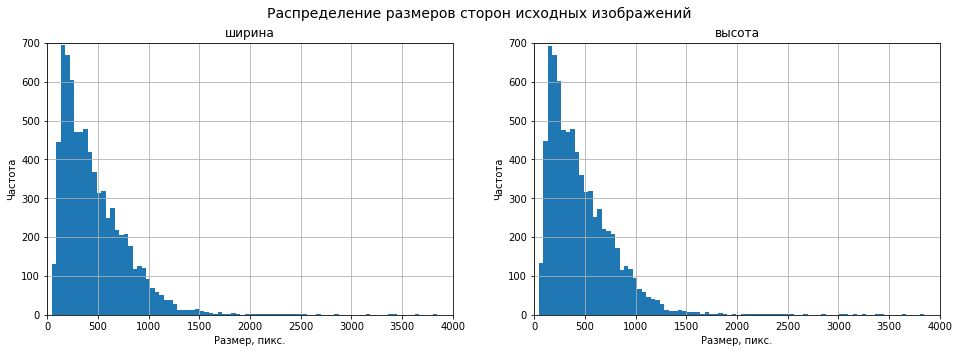

In [5]:
# вывод статистических данных и распределения ширины и высоты исходных фотографий
display(data[['width', 'height']].describe())

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Распределение размеров сторон исходных изображений', fontsize=14)
data['width'].hist(bins=100, ax=ax[0])
ax[0].set_xlim(0, 4000)
ax[0].set_ylim(0, 700)
ax[0].set_title(label = 'ширина')
ax[0].set(xlabel='Размер, пикс.', ylabel='Частота')
data['height'].hist(bins=100, ax=ax[1])
ax[1].set_xlim(0, 4000)
ax[1].set_ylim(0, 700)
ax[1].set_title(label = 'высота')
ax[1].set(xlabel='Размер, пикс.', ylabel='Частота')
plt.show()

Исходные фотографии имеют формат 1:1 с размером стороны от 47 до 4466 пикселей.  
Среднее значение стороны фотографии 464 пикселя, медианное - 384 пикселя.

При унификации размеров фотографий целесообразно применить значение по умолчанию в 256 пикселей.

Файл с названием `007612.jpg` не читается, его размеры не определяются. Для обучения модели он не подходит, поэтому удалим данную строчку из датасета.

In [6]:
# удаление строки с пропуском
data = data.dropna()

# отображение результата
data.info()
display(data.tail(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7590 entries, 0 to 7589
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  7590 non-null   object 
 1   real_age   7590 non-null   int64  
 2   width      7590 non-null   float64
 3   height     7590 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 296.5+ KB


,file_name,real_age,width,height
7585,007607.jpg,10,251.0,250.0
7586,007608.jpg,14,159.0,159.0
7587,007609.jpg,37,260.0,260.0
7588,007610.jpg,28,116.0,116.0
7589,007611.jpg,20,278.0,278.0


Выполним преобразование фотографий в поток изображений с помощью `ImageDataGenerator`. При этом применим масштабирование, чтобы значения находились в диапазоне от 0 до 1, что способствует лучшей обучаемости модели. Данные о признаках (фото) и целевом признаке (возрасте) возьмем из подготовленного датасета.

Found 7590 validated image filenames.
CPU times: user 2.08 s, sys: 740 ms, total: 2.82 s
Wall time: 1min 41s


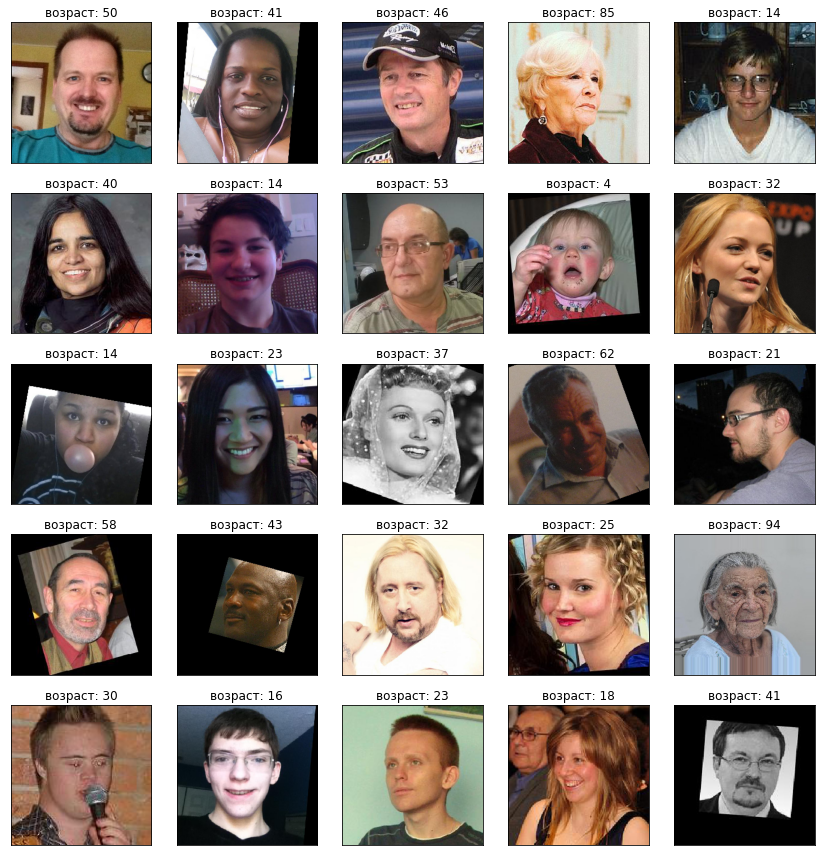

In [7]:
%%time

# загрузка фотографий в поток изображений
datagen = ImageDataGenerator(rescale=1/255)
images_flow = datagen.flow_from_dataframe(dataframe=data, directory=PATH_IMG, x_col='file_name', y_col='real_age',
                                          class_mode='raw', seed=RST)

# просмотр изображений
features, target = images_flow[0]
fig = plt.figure(figsize=(12,12))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title('возраст: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В выборке присутствуют цветные и чернобелые фотографии лиц людей c разного ракурса, в основном хорошего качества.

### 1.1. <a id='toc1_1_'></a>[Вывод по результатам раздела](#toc0_)

По результатам исследовательского анализа можно сделать следующие выводы:

- В исходных данных содержится более 7,5 тыс. фотографий лиц людей с указанием их возраста.
- Дубликатов нет. Файлы фотографий хранятся в формате со сжатием `.jpg`. Исходный размер изображений различен.
- Диапазон возрастов содержит реальные значения от 1 до 100 лет. Среднее значение и медиана составляют 31,2 года и 29 лет соответственно. Распределение возрастов имеет форму распределения Пуассона с положительной асимметрией и выбросами.
- Наблюдается увеличенное количество изображений в диапазоне возрастов от 1 до 7 лет (за исключением возраста 3 года), а также и в "круглых" датах, кратных 10 и в возрасте 25 лет. Предположительно в выборку была добавлена группа фотографий детей дошкольного возраста для более четкой их идентификации, а всплески на "круглых" датах вероятно обусловлены округлением возраста при его приблизительном определении.

В выборке содержится меньшее количество фотографий для людей в возрасте старше 50 - 60 лет. Это может ухудшить точность предсказаний возраста для данной группы лиц, что в свою очередь повлияет на реализацию одной из задач: "анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы".  
Также в выборке содержится меньшее количество фотографий для возраста 8 - 13 лет, что может повлиять на точность определения возраста в данном диапазоне и на реализацию другой задачи: "контролировать добросовестность кассиров при продаже алкоголя".  
Обе потенциальные проблемы можно попробовать решить за счет увеличения объема выборки путем аугментации (вертикальное и горизонтальное отражение, сдвиги и повороты изображений). 

## 2. <a id='toc2_'></a>[Обучение модели](#toc0_)

Код для обучения модели:

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam



def load_train(path):

    # формирование датафрейма из названий изображений и значений возраста
    data = pd.read_csv(path + 'labels.csv')

    # формирование потока изображений для обучения
    # из папки на основе созданного датафрейма
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split=.2)
    train_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(256, 256),
        batch_size=32,
        subset='training',
        seed=12345)
        
    return train_flow


def load_test(path):

    # формирование датафрейма из названий изображений и значений возраста
    data = pd.read_csv(path + 'labels.csv')

    # формирование потока изображений для тестирования
    # из папки на основе созданного датафрейма
    test_datagen = ImageDataGenerator(rescale=1/255, validation_split=.2)
    test_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(256, 256),
        batch_size=32,
        subset='validation',
        seed=12345)
        
    return test_flow


def create_model(input_shape):

    # создание модели ResNet50 для регрессии с функцией потерь MSE и метрикой MAE
    model = Sequential()
    model.add(ResNet50(input_shape=input_shape, weights='imagenet', include_top=False))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    print(model.summary())
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    # обучение модели
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2, shuffle=True)
    return model
```

Результат отработки модели:

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 48s - loss: 194.2633 - mae: 10.4869 - val_loss: 384.0676 - val_mae: 14.5776
Epoch 2/10
190/190 - 40s - loss: 100.4093 - mae: 7.6493 - val_loss: 336.2774 - val_mae: 15.2645
Epoch 3/10
190/190 - 40s - loss: 67.0385 - mae: 6.2434 - val_loss: 391.4141 - val_mae: 14.7216
Epoch 4/10
190/190 - 40s - loss: 44.9415 - mae: 5.1608 - val_loss: 171.2853 - val_mae: 9.8116
Epoch 5/10
190/190 - 39s - loss: 31.1683 - mae: 4.3086 - val_loss: 86.3822 - val_mae: 7.1877
Epoch 6/10
190/190 - 39s - loss: 23.0870 - mae: 3.7105 - val_loss: 82.5687 - val_mae: 6.7411
Epoch 7/10
190/190 - 39s - loss: 20.2139 - mae: 3.4590 - val_loss: 100.6875 - val_mae: 7.5350
Epoch 8/10
190/190 - 39s - loss: 18.0136 - mae: 3.2883 - val_loss: 78.7409 - val_mae: 6.5925
Epoch 9/10
190/190 - 42s - loss: 14.9635 - mae: 2.9695 - val_loss: 95.1767 - val_mae: 7.1059
Epoch 10/10
190/190 - 57s - loss: 11.6543 - mae: 2.6042 - val_loss: 66.1427 - val_mae: 6.2242
48/48 - 9s - loss: 66.1427 - mae: 6.2242
Test MAE: 6.2242
```

## 3. <a id='toc3_'></a>[Анализ обученной модели. Выводы](#toc0_)

В рамках проведения исследования была построена сверточная нейросеть с архитектурой `ResNet`, которая позволяет избежать проблемы затухающего градиента в глубоких нейросетях за счет создания дополнительных связей внутри сети (shortcut connections).  
Для решения задачи регрессии - определение возраста человека по фотографии - взята основа (backbone) нейросети `ResNet50` из библиотеки `Keras` с отключенными последними слоями. Вместо них добавлен слой из одного нейрона для получения количественных предсказаний с функцией активации `ReLU` которая приводит к нулю отрицательные значения и сохраняет положительные.  
В качестве алгоритма оптимизации вместо градиентного спуска выбран адаптивный алгоритм `Adams`, обеспечивающий автоматический подбор шага обучения и подбор различных параметров для разных нейронов, что обеспечивает более высокую скорость обучения по сравнению с другими алгоритмами, в частности с градиентным спуском.  
В качестве функции потерь в модели взята средняя квадратичная ошибка MSE, обеспечивающая более высокую скорость обучения. В качестве метрики заданием для исследования определена среднаа абсолютная ошибка MAE.

- Требуемое значение метрики MAE < 8 достигнуто моделью после пятой эпохи. По итогам 10 эпох получено значение MAE = 6,2.

Следует отметить, что для достижения требуемого значения метрики не потребовалось применение аугментации.  
Отдельно проведенное исследование модели с идентичными параметрами и с применением аугментации в виде отражения, сдвигов и поворотов изображений:
```python
vertical_flip=True,
horizontal_flip=True,
width_shift_range=.2,
height_shift_range=.2,
rotation_range=20
```
показало результаты хуже, чем без аугментации и менее стабильные. По итогам 20 эпох значение метрики MAE составило 8,79, хотя на предыдущих эпохах было меньше 8 и даже меньше 7 (ниже часть итоговая часть лога модели с аугментацией).
```
Epoch 15/20
190/190 - 127s - loss: 88.6459 - mae: 7.2291 - val_loss: 169.9689 - val_mae: 10.0950
Epoch 16/20
190/190 - 125s - loss: 81.1123 - mae: 6.8961 - val_loss: 174.3318 - val_mae: 9.6579
Epoch 17/20
190/190 - 123s - loss: 81.0261 - mae: 6.8718 - val_loss: 148.0345 - val_mae: 9.0532
Epoch 18/20
190/190 - 124s - loss: 74.2410 - mae: 6.5712 - val_loss: 109.5045 - val_mae: 7.5678
Epoch 19/20
190/190 - 125s - loss: 73.2119 - mae: 6.5393 - val_loss: 82.8078 - val_mae: 6.7789
Epoch 20/20
190/190 - 122s - loss: 76.8839 - mae: 6.6568 - val_loss: 140.5842 - val_mae: 8.7933
48/48 - 9s - loss: 140.5842 - mae: 8.7933
Test MAE: 8.7933
```

- Перед исследованием и моделью ставились две задачи:  
    1) Анализ покупок и предложение товаров, которые могут заинтересовать покупателей определенной возрастной группы.  
    2) Контроль добросовестности кассиров при продаже алкоголя.

Полученная погрешность модели в размере 6,2 лет позволяет достаточно уверенно относить пользователей к той или иной возрастной группе и, соответственно, выполнять первую задачу по дополнительным продажам и увеличению выручки.  
Вторая задача по контролю продажи алкоголя может выполняться моделью с ошибкой, поэтому требует введения дополнительных организационных мероприятии.